# Detección de anomalías - Big Mart Sales

En esta práctica de detección de anomalías vamos a trabajar con el dataset **Big Mart Sales**.

Nuestro objetivo será ver la relación entre el precio de los artículos y las ventas de los mismos y detectar *outliers* en esos parámetros.

In [3]:
!pip install pyod
!pip install combo # Para combinar varios modelos con el algoritmo Feature Bagging


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42906 sha256=7da36fa7124bfc5300780eaa799df1b24176ec840b89bf62d01af698e9ecb79d
  Stored in directory: c:\users\hugo.peralta.munoz\appdata\local\pip\cache\wheels\21\e7\9e\8baa8e183e9e3d7e37b74c5c0083462d91fb34123b92abb6ad
Successfully built combo



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

In [8]:
bigmart_df = pd.read_csv("Train.csv")

## Importación de modelos

In [5]:
# Angle-Based Outlier Detection
# Basado en densidad
from pyod.models.abod import ABOD

# Cluster-Based Local Outlier Factor
# Basado en centroides
from pyod.models.cblof import CBLOF

# Feature Bagging 
# Divide el dataset en grupos y aplica diferentes modelos a cada subconjunto (LOF, KNN, ...)
from pyod.models.feature_bagging import FeatureBagging

# Histogram-Based Outlier Score
# Basado en distribuciones
from pyod.models.hbos import HBOS

# Isolation Forest 
# Usa arboles de decision pero no es jerarquico 
from pyod.models.iforest import IForest

# K-Nearest Neighbors
from pyod.models.knn import KNN

# Local Outlier Factor
# Basado en densidad
from pyod.models.lof import LOF

## Exploración y visualización de los datos

In [9]:
bigmart_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [10]:
bigmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [11]:
bigmart_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [12]:
bigmart_df["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [15]:
bigmart_df.replace(["low fat", "LF", "reg"], ["Low Fat", "Low Fat", "Regular"], inplace=True)

In [16]:
bigmart_df["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [17]:
bigmart_df["Item_Type"].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [19]:
bigmart_df["Outlet_Identifier"].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [18]:
bigmart_df["Outlet_Type"].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [20]:
bigmart_df["Outlet_Size"].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [21]:
bigmart_df["Outlet_Location_Type"].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [22]:
# Valores nulos por cada tipo

bigmart_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

<Figure size 1600x1200 with 0 Axes>

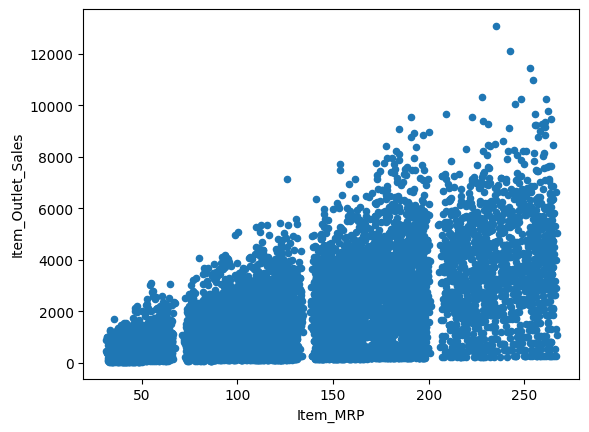

In [28]:
# MRP vs Item Outlet Sales

plt.figure(figsize=(16, 12))
bigmart_df.plot.scatter("Item_MRP", "Item_Outlet_Sales")
plt.show()

## Escalado de datos 

Hay mucha diferencia en la escala de ambos atributos ya que son muy dispares. Se puede hacer el escalado o no pero en términos generales también aumenta la velocidad del entrenamiento del modelo.

In [29]:
# Escalamos los dos atributos en el rango de 0 a 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
bigmart_df[["Item_MRP", "Item_Outlet_Sales"]] = scaler.fit_transform(bigmart_df[["Item_MRP", "Item_Outlet_Sales"]])

bigmart_df[["Item_MRP", "Item_Outlet_Sales"]]

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651
...,...,...
8518,0.777729,0.210293
8519,0.326263,0.039529
8520,0.228492,0.088850
8521,0.304939,0.138835


In [31]:
# Pasamos las columnas a dos arrays de NumPy 

X = bigmart_df[["Item_MRP", "Item_Outlet_Sales"]].to_numpy() 

X

array([[0.92750715, 0.28358666],
       [0.0720684 , 0.03141895],
       [0.46828841, 0.15811486],
       ...,
       [0.22849221, 0.08885035],
       [0.30493925, 0.13883505],
       [0.18750976, 0.05610527]])

## Creación del diccionario de los modelos

Creamos un diccionario con los algoritmos que queremos utilizar.

Vamos a considerar hipotéticamente que los outliers están en torno al 5% de las observaciones que son diferentes al resto, por tanto, el parámetro `contamination` lo ponemos a 0.05, almacenaremos este valor en una variable denominada `outliers_fraction`.

In [32]:
outliers_fraction = 0.05

classifiers = {
    "ABOD": ABOD(contamination=outliers_fraction),
    "CBLOF": CBLOF(contamination=outliers_fraction, check_estimator=False),
    "FeatureBagging": FeatureBagging(LOF(n_neighbors=35) ,contamination=outliers_fraction, check_estimator=False),
    "HBOS": HBOS(contamination=outliers_fraction),
    "IForest": IForest(contamination=outliers_fraction),
    "KNN": KNN(contamination=outliers_fraction),
    "LOF": LOF(n_neighbors=35, contamination=outliers_fraction)
}

# check_estimator=False hace que no se compruebe que el estimador (la clase que implementa el algoritmo)
# cumple una serie de estandares como que implementa unos metodos determinados
# de esta forma va mas rapido

## Detección de Outliers

Aplicamos los datos a cada modelo y vemos cómo predice cada uno de los outliers.

In [ ]:
for clf_name, clf in classifiers.items():
    # Hacer una copia del dataframe 
    copy_df = bigmart_df.copy()

    # Extraer la informacion sobre los outliers

    # Añadimos la columna de outliers al dataframe

    # Separa los inliners y outliers 

    # Muestra numero de inliners y outliers 

    # Muestra la grafica 